In [1]:
import stim
print(stim.__version__)
import numpy as np
import time
import operator
from collections import Counter
from functools import reduce
from itertools import product
import sys
from typing import List, Tuple


1.15.0


# Demo. Quantum Reed-Muller Code

### 1. Classical RM code: Generator Matrix, Decoder

In [2]:
def RM_generator_matrix(r: int, m: int, variation: str) -> Tuple[np.ndarray, List[Tuple[int]]]:
    
    n = 2 ** m
    monomials = []

    for deg in range(r + 1):
        for bits in product([0, 1], repeat=m):
            if sum(bits) == deg:
                monomials.append(bits)

    G = []
    for mono in monomials:
        row = []
        for i in range(n):
            x = [int(b) for b in bin(i)[2:].rjust(m, '0')]
            val = 1
            for a, xi in zip(mono, x):
                if a == 1:
                    val &= xi
            row.append(val)
        G.append(row)
    
    G = np.array(G, dtype=int)
    
    if variation == "None":
        G_final = G
        monomials_final = monomials
    
    if variation == "punctured":
        # Remove the first column (corresponding to evaluation point 0...0)
        G_final = G[:, 1:]
        monomials_final = monomials

    if variation == "shortened":
        # Remove the first column (corresponding to evaluation point 0...0)
        G_final = G[:, 1:]

        # Remove the first row (corresponding to constant polynomial = all-0 monomial)
        G_final = G_final[1:, :]
        monomials_final = monomials[1:]
        
    return G_final, monomials_final

In [3]:
r = 1
m = 4
N = 2 ** m -1
d = 2 ** (r+1) - 1
stabilizers_x, _ = RM_generator_matrix(r, m, variation="shortened")

### Recursive List Decoder

In [5]:
def repetition_ml_decoder(y: np.ndarray) -> np.ndarray:
    """
    RM(0, m): all-0 or all-1 codeword; choose the better one
    """
    factor = 0.99 # Avoid extreme values of y (+1 or -1)
    score0 = np.prod((1 + factor * y) / 2)   # likelihood of all 0 codeword (+1)
    score1 = np.prod((1 - factor * y) / 2)   # likelihood of all 1 codeword (-1)

    c0 = np.ones_like(y)
    c1 = -np.ones_like(y)

    # print(f"Repetition ML scores: {score0:.4f} (0), {score1:.4f} (1)")
    if score0 > score1:
        return c0
    elif score1 > score0:
        return c1
    else:
        # If scores are equal, return with equal probability, unbiased
        return c0 if np.random.rand() < 0.5 else c1

def rm_list_decode(y, r, m, L=4) -> np.ndarray:
    """
    Recursive list decoder Ψ_m^r(L)
    y: input vector in [-1, 1]^n
    r, m: RM(r, m)
    L: list size
    Returns: list of (codeword, path_cost)
    """
    # print("r = ", r, ", m = ", m)
    factor = 0.99  # Avoid extreme values of y (+1 or -1)
    N = len(y)

    # Base cases
    if r == 0:
        return repetition_ml_decoder(y)
    if r == m:
        # RM(m,m) is full space — just use hard-decision
        return np.sign(y + (1-factor) * np.random.uniform(-1, 1, size=N))  # Add noise to avoid extreme values

    yL, yR = y[:N//2], y[N//2:]

    # Step 1: estimate v from componentwise product y_v = yL * yR
    y_v = yL * yR
    v_hat = rm_list_decode(y_v, r-1, m-1, L)

    # Step 2: for each v_hat, estimate u_hat
    y_hat = yR * v_hat  # Compute ŷ = yR * v_hat
    # Compute y_u = (yL + ŷ) / (1 + yL * ŷ)
    denom = 1 + factor * yL * y_hat
    y_u = (yL + y_hat) / denom
    u_hat = rm_list_decode(y_u, r, m-1, L)

    cw = np.concatenate([u_hat, u_hat * v_hat])

    return cw

In [10]:
# Test the RM list decoder with random codewords
failure = 0
sample_num = 1000

r = 1
m = 3
noise = 0.01
G, _ = RM_generator_matrix(r, m, variation="None")

for i in range(sample_num):
    # Generate a random codeword
    true_msg = np.random.randint(0, 2, G.shape[0])
    true_cw = (true_msg @ G) % 2
    noisy_cw = (true_cw + np.random.binomial(1, noise, len(true_cw))) % 2
    y = (-1) ** noisy_cw
    decoded_cw = rm_list_decode(y, r, m, L=4)
    decoded_cw = (1 - decoded_cw) // 2  # Convert from ±1 to {0, 1}
    if not np.array_equal(true_cw, decoded_cw):
        failure += 1
failure_rate = failure / sample_num
print("Failure rate: ", failure_rate)

Failure rate:  0.002


Then extend to the punctured and shortened version. The idea is: Given a noisy codeword, we first insert $\pm 1$ at the 0-th bit (the punctured one), decode with the original RM decoder, and compare which one is closer to the original noisy codeword. We choose the closer one as the decoding result. 

For the shortened version, just use the same decoder as the punctured one but always insert 0 at the 0-th qubit.

In [16]:
# Test the punctured version of RM list decoder
failure = 0
sample_num = 1000000

r = 2
m = 4
noise = 0.005
variation = "punctured"  # "shortened", "punctured", "None"
G, _ = RM_generator_matrix(r, m, variation=variation)

weight_list = []

for i in range(sample_num):
    # Generate a random codeword
    true_msg = np.random.randint(0, 2, G.shape[0])
    true_cw = (true_msg @ G) % 2
    noisy_cw = (true_cw + np.random.binomial(1, noise, len(true_cw))) % 2
    
    # Insert the 0-th bit (punctured)
    y = (-1) ** noisy_cw
    if variation == "punctured":
        y0 = np.insert(y, 0, 1)  # Insert a 1 at the 0-th bit
        y1 = np.insert(y, 0, -1)  # Insert a -1 at the 0-th bit
        decoded_cw0 = rm_list_decode(y0, r, m, L=4)
        decoded_cw1 = rm_list_decode(y1, r, m, L=4)
        overlap0 = np.sum(y0 * decoded_cw0)
        overlap1 = np.sum(y1 * decoded_cw1)
        if overlap0 > overlap1:
            decoded_cw = decoded_cw0
        else:
            decoded_cw = decoded_cw1
        decoded_cw = (1 - decoded_cw[1:]) // 2  # Convert from ±1 to {0, 1}
    elif variation == "shortened":
        y0 = np.insert(y, 0, 0)
        decoded_cw = rm_list_decode(y0, r, m, L=4)
        decoded_cw = (1 - decoded_cw[1:]) // 2  # Convert from ±1 to {0, 1}
    else:
        decoded_cw = rm_list_decode(y, r, m, L=4)
        decoded_cw = (1 - decoded_cw) // 2  # Convert from ±1 to {0, 1}
    
    if not np.array_equal(true_cw, decoded_cw):
        failure += 1
    weight_list.append(np.sum(decoded_cw)) # Check the weight distribution of decoded codeword

failure_rate = failure / sample_num
print("Failure rate: ", failure_rate)
weight_list = np.array(weight_list)
print("Even/Odd: ", np.sum(weight_list % 2 == 0) / sample_num) 
# for punctured version, should be close to 0.5; for shortened/original version, should be close to 1.0

Failure rate:  0.002558
Even/Odd:  0.500359


### 2. Non-Fault-Tolerant Encoding

In [ ]:
bin_wt = lambda i: bin(i)[2:].count('1')
bit_rev = lambda t, m: int(bin(t)[2:].rjust(m, '0')[::-1], 2)
int2bin = lambda i, m: [int(c) for c in bin(i)[2:].rjust(m, '0')]
bin2int = lambda l: int(''.join(map(str, l)), 2)

In [ ]:
def QRM_encode(rx: int, rz: int, m: int, noise_profile: list, observable_type: str, punctured: bool = True, final_meas: str = "Z") -> stim.Circuit:
    p1, p2, p_M, p_R = noise_profile
    N = 2**m
    data_coords = [(0,0)]
    for r in range(m):
        if r % 2 == 0:
            coords_shifted = [(x + 2**(r//2), y) for (x, y) in data_coords]
        else:
            coords_shifted = [(x, y + 2**(r//2)) for (x, y) in data_coords]
        data_coords += coords_shifted

    coord_to_index = {coord: i for i, coord in enumerate(data_coords)}

    if punctured:
        del coord_to_index[(0,0)] # Remove the punctured qubit at (0,0)

    qubit_indices = list(coord_to_index.values())

    # non-punctured or punctured code
    full_circuit = stim.Circuit()
    # repeat_circuit = stim.Circuit()

    # QUBIT_COORDS annotations
    for coord, index in coord_to_index.items():
        full_circuit.append_operation("QUBIT_COORDS", [index], list(coord))

    # Fix! For |+> state, need to prepare the QRM(rz,rx,m) code in |0> state then 
    # apply transversal hadamard gates to prepare the |+> state.
    X_state_indices = []
    Z_state_indices = []
    prepared_indices = []
        
    if observable_type == "Z":
        for i in qubit_indices:
            if bin_wt(i) <= rx:
                X_state_indices.append(i)
            elif bin_wt(i) >= m - rz:
                Z_state_indices.append(i)
            else:
                prepared_indices.append(i)
        full_circuit.append_operation("RX", X_state_indices)
        full_circuit.append_operation("Z_ERROR", X_state_indices, p_R)
        full_circuit.append_operation("R", Z_state_indices + prepared_indices)
        full_circuit.append_operation("X_ERROR", Z_state_indices + prepared_indices, p_R)
    if observable_type == "X": # flip the state preparation
        for i in qubit_indices:
            if bin_wt(i) <= rz:
                Z_state_indices.append(i)
            elif bin_wt(i) >= m - rx:
                X_state_indices.append(i)
            else:
                prepared_indices.append(i)
        full_circuit.append_operation("RX", X_state_indices + prepared_indices)
        full_circuit.append_operation("Z_ERROR", X_state_indices + prepared_indices, p_R)
        full_circuit.append_operation("R", Z_state_indices)
        full_circuit.append_operation("X_ERROR", Z_state_indices, p_R)

    full_circuit.append("TICK")

    # non-FT hypercube encoding circuit
    for t in range(m): # rounds
        sep = 2 ** t
        CNOT_indices = []
        for i in qubit_indices:
            if int2bin(i,m)[-1-t] == 0 and i + sep < N:
                if observable_type == "Z":
                    CNOT_indices += [i, i + sep]
                else:
                    CNOT_indices += [i + sep, i]      
        full_circuit.append_operation("CNOT", CNOT_indices)
        full_circuit.append("DEPOLARIZE2", CNOT_indices, p2)
        full_circuit.append("TICK")

    # Final measurement for logical observables
    if final_meas == "Z":
        full_circuit.append_operation("X_ERROR", qubit_indices, p_M)
        full_circuit.append_operation("M", qubit_indices)
    if final_meas == "X":
        full_circuit.append_operation("Z_ERROR", qubit_indices, p_M)
        full_circuit.append_operation("MX", qubit_indices)
    if final_meas == "Y":
        full_circuit.append_operation("Y_ERROR", qubit_indices, p_M)
        full_circuit.append_operation("MY", qubit_indices)

    return full_circuit

# An optimization: if the control qubit is zero, omit the CNOT gate at the first time step

In [ ]:
# If not a punctured code, need to satisfy rx + rz <= m - 2, otherwise no logical qubit encoded
# If punctured code, need to satisfy rx + rz <= m - 1, otherwise no logical qubit encoded
punctured = True  # Set to False for non-punctured code
noise_profile = [0.001] * 4

# [[15,1,3]] quantum Reed-Muller code with rx=1, rz=2, m=4
circuit_ZZ = QRM_encode(1, 2, 4, noise_profile, "Z", punctured, final_meas="Z")
circuit_ZX = QRM_encode(1, 2, 4, noise_profile, "Z", punctured, final_meas="X")
circuit_XZ = QRM_encode(1, 2, 4, noise_profile, "X", punctured, final_meas="Z")
circuit_XX = QRM_encode(1, 2, 4, noise_profile, "X", punctured, final_meas="X")

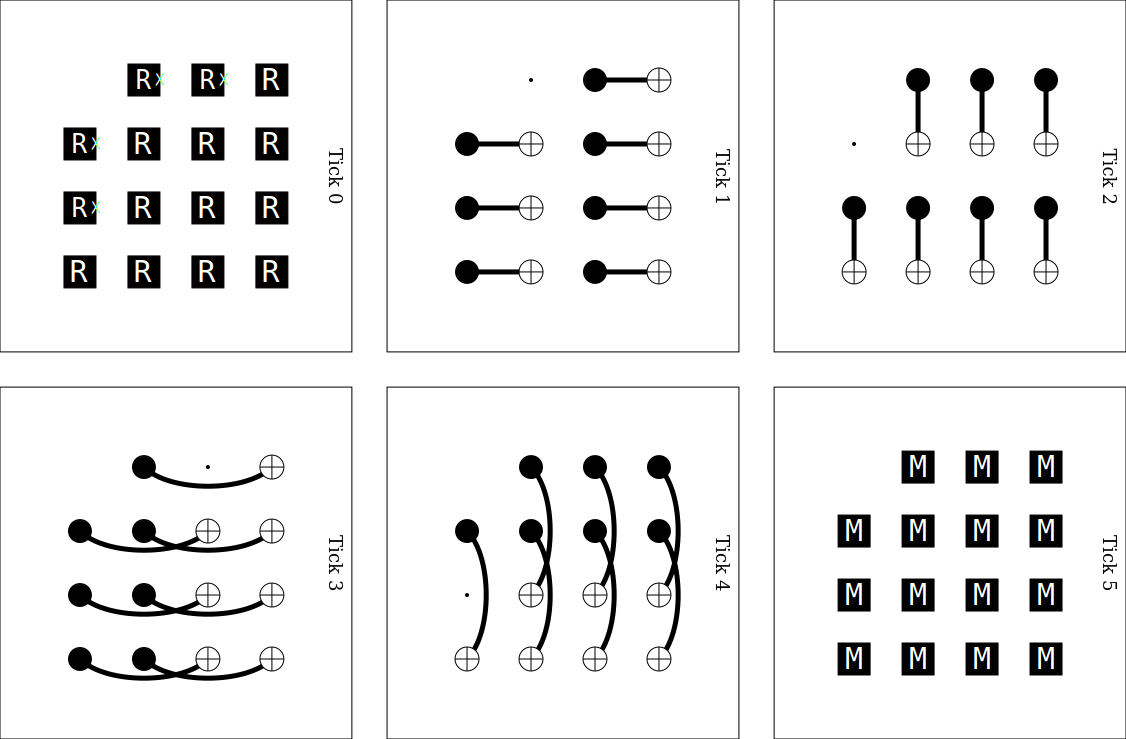

In [ ]:
circuit_ZZ.without_noise().diagram("detslice-with-ops-svg")

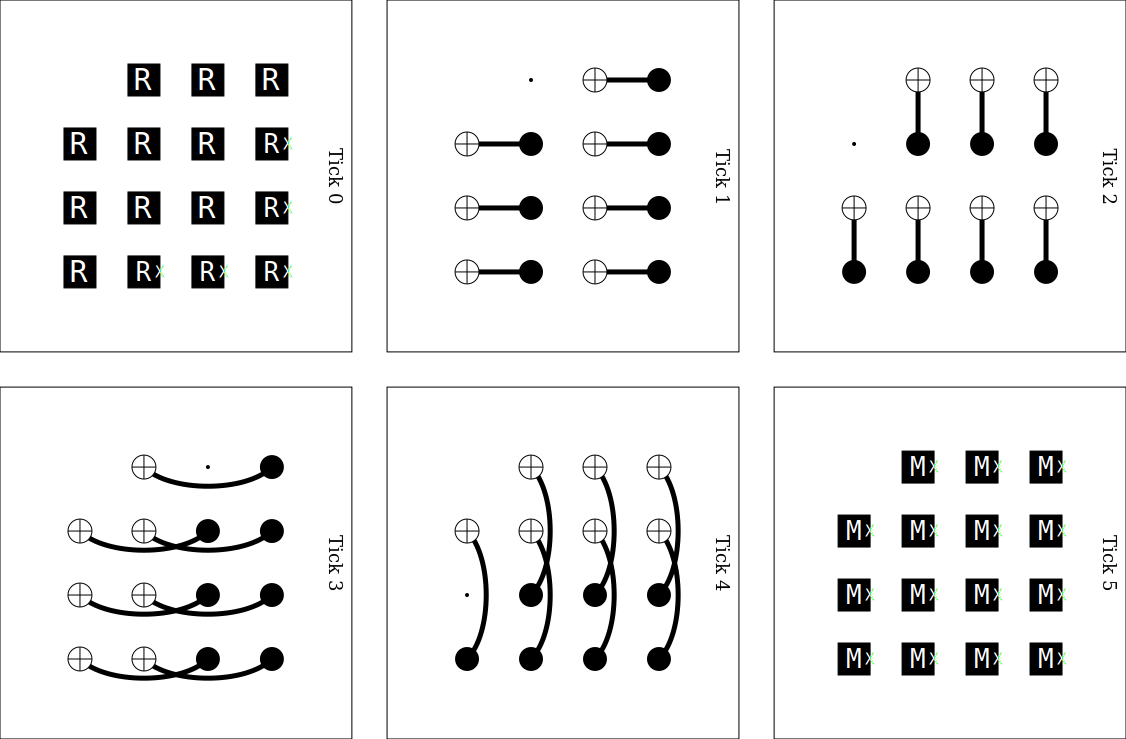

In [ ]:
circuit_XX.without_noise().diagram("detslice-with-ops-svg")

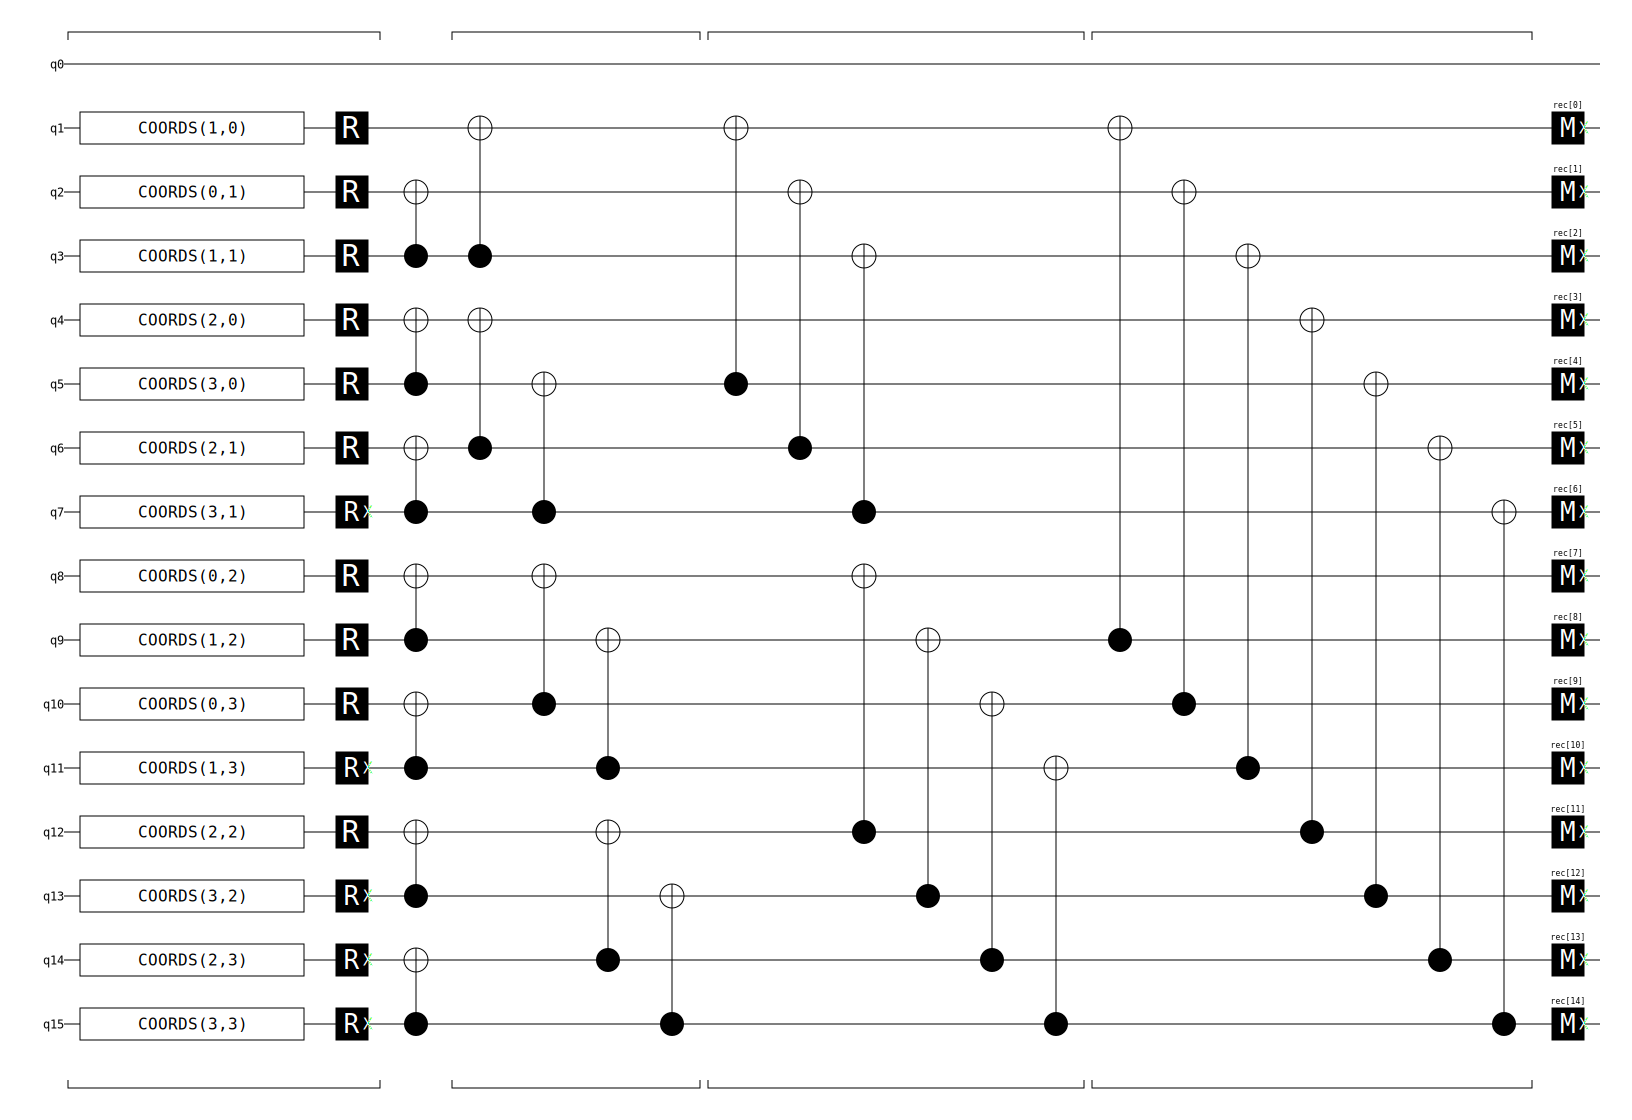

In [ ]:
circuit_XX.without_noise().diagram("timeline-svg")

In [ ]:
circuit_XY = QRM_encode(1, 2, 4, noise_profile, "X", punctured, final_meas="Y")

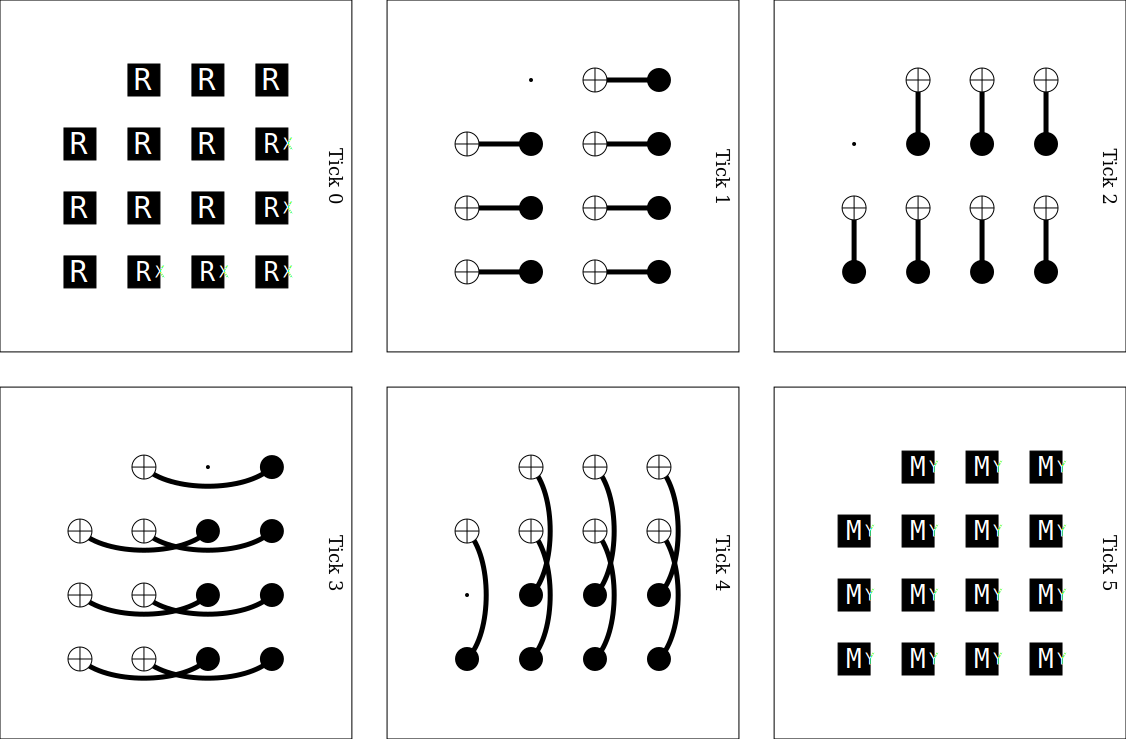

In [ ]:
circuit_XY.without_noise().diagram("detslice-with-ops-svg")

### Measurement Results of PQRM Codes
Let's briefly verify that we have the correct code construction.  
(1) After preparing $|0\rangle_L$ state, measure all the qubits in Z basis should give a vector representing an X-stabilizer (a vector in $\overline{RM}(r_x, m)$). The product of these measurement results should give the value of logical Z, which should be +1. Therefore, the weight of the measurement results should be even. $N-1$ minus the maximum weight observed in the measurement results give the minimum $X$-distance of the code.  
(2) Prepare $|0\rangle_L$, measure all the qubits in X basis. The measurement results will give the vectors in the dual of $\overline{RM}(r_x, m)$, which is $RM^{\star}(m-r_x-1, m)$ (this includes both even and odd weights). Another way to understand this is that the dual of $\overline{RM}(r_x, m)$ ($X$-stabilizers) is exactly the $Z$-stabilizers and the $Z$-logical operators. Therefore, the minimal weight in the measurement results give the $Z$-distance. The product will give measurement result of logical X, so it shoul be random ($\pm 1$) with equal 1/2 probability.

In [ ]:
# Sample the measurement results
sample_num = 100
sampled_results_ZZ = circuit_ZZ.without_noise().compile_sampler().sample(sample_num)
np.sum(sampled_results_ZZ, axis=1)  # should be 0, 1, or 2


array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 0, 8, 8, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 8, 0, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

We can also see that the $X$-distance is $15-8=7$.

In [ ]:
sampled_results_ZX = circuit_ZX.without_noise().compile_sampler().sample(sample_num)
print(np.sum(np.sum(sampled_results_ZX, axis=1) % 2)/sample_num)
np.sum(sampled_results_ZX, axis=1)

0.46


array([ 8,  7,  8,  7,  7,  7,  7, 10,  7,  9,  7,  7,  7,  8,  4,  8,  8,
        6,  3,  4,  8,  5,  6,  6,  8,  5, 10,  7,  6,  8, 10,  8,  8,  6,
        4,  8,  6, 10,  9,  7, 10,  9,  6,  5,  8,  5,  8,  9, 11,  9,  6,
        8, 10,  6,  8,  6, 10,  8,  3,  5,  6, 11,  6,  5, 11,  9,  8,  8,
        8,  9,  7,  5,  7,  7,  8,  6, 10,  7,  8,  7,  7,  7, 10,  5,  9,
        7,  7, 10,  9, 10,  7,  4, 10,  7,  6,  4,  7,  8, 11,  8])

We can also see that the $Z$-distance is $3$ (sample for a few times you should see 3).

(3) After preparing $|+\rangle_L = (|0\rangle_L+|1\rangle_L)/\sqrt{2}$ state, measure all the qubits in Z basis should give a vector representing an X-stabilizer (a vector in $\overline{RM}(r_x, m)$) or its all-bit-flipped version (assuming there is only 1 logical qubit), thus a vector in $RM^{\star}(r_x,m)$. We will see both odd and even weights. The product of these measurement results should give the value of logical Z, which should be random $\pm 1$. Therefore, the weight of the measurement results should be even. The minimal weight (non-zero) gives the $X$-distance.  
(4) Prepare $|+\rangle_L$ measure all the qubits in X basis. This is equivalent as measuring $|0\rangle_L$ encoded in $PQRM(r_z,r_x,m)$ code in $Z$-basis. The measurement results will give vectors representing $X$-stabilizers, which is $\overline{RM}(r_z,m)$. $N-1$ minus the maximal weight observed gives the minimum $Z$-distance.

In [ ]:
# Sample the measurement results
sampled_results_XZ = circuit_XZ.without_noise().compile_sampler().sample(sample_num)
# np.shape(sampled_results)
print(np.sum(np.sum(sampled_results_XZ, axis=1) % 2)/sample_num)
np.sum(sampled_results_XZ, axis=1)  # should be 0, 1, or 2

0.48


array([ 8,  7,  7,  7,  7,  8,  8,  8,  7,  7,  8,  7,  7,  8,  7,  7,  8,
        7,  8,  7,  8,  7,  8,  7, 15,  8,  8,  7,  8,  7,  7,  8,  8,  8,
        8,  8,  8,  7, 15,  7,  7,  8,  7,  8,  8,  8, 15,  8,  7,  8,  7,
        8,  7,  7,  8,  8,  8,  7,  8,  8,  7,  8,  8,  7,  8,  8,  7,  7,
        8,  7,  7,  8,  7,  8,  8,  7,  8, 15,  8,  7,  8,  7,  0,  7,  8,
        7,  7,  8,  8, 15,  8,  7,  8,  8,  7,  8,  7,  8,  8,  7])

It shows that the $X$-distance is $7$.

In [ ]:
sampled_results_XX = circuit_XX.without_noise().compile_sampler().sample(sample_num)
np.sum(sampled_results_XX, axis=1)  # should be 0, 1, or 2

array([ 4,  6,  8,  8,  6,  8,  4,  8,  8,  8,  8,  6,  6,  8,  8,  4,  8,
        4,  8,  8, 10,  8,  8,  4,  8,  8,  8,  4,  8,  6,  8,  8,  6,  6,
        8,  8,  6,  8,  6,  6,  6,  8,  8,  8,  6,  8,  6,  6,  4,  6,  6,
        8,  6,  4,  4,  8,  8,  8,  8,  6,  4,  6,  8,  8,  6, 10,  6,  8,
        6, 10,  4,  8,  4,  8, 10,  6,  8,  4,  8,  4, 10,  6,  8,  4,  8,
       10,  6, 10,  8,  8,  6,  8, 10,  6, 10, 12, 10,  8,  6,  4])

The $Z$-distance is then $15-12=3$.

### Noisy Measurements and Recursive List Decoding  
We'll do two experiments:  
(1) Non-FT encoding of PQRM code in logical $|0\rangle$ state, transversal measurement in Z-basis, decoding and infer the value of Z logical operator (the left vertical line).  
(2) Non-FT encoding of PQRM code in logical $|+\rangle$ state, transversal measurement in X-basis, decoding and infer the value of X logical operator (the top horizontal line).

In [ ]:
# Generate logical operators

def generate_logical_operators(r: int, monomial: Tuple[int], punctured: bool = True) -> List[int]:
    """
    Generate logical operators for the quantum Reed-Muller code.
    r, m: parameters of the QRM code, r is either rx or rz
    monomial: tuple representing the monomial specifying the logical operator
    punctured: whether the code is punctured or not
    Returns a list of tuples representing the logical operators.
    """

    m = len(monomial)
    monomial_weight = sum(monomial)
    if m - monomial_weight > r:
        raise ValueError("The monomial has more than r zeros.")
    
    support = []

    for i in range(1, 2**m):
        b = list(map(int, bin(i)[2:].rjust(m, '0')[::-1]))  # Binary string to list of bits
        match = True
        for k in range(m):
            if monomial[k] == 0 and b[k] != 0:
                match = False
                break
        if match:
            support.append(i)
    
    return support

In [ ]:
# Generate logical operator given the monomial 
rx = 2
rz = 3
m = 6
monomial_Z = [0, 1, 0, 1, 0, 1]  # Example monomial for logical operator, e.g., x_0 * x_2 * x_4
# Logical Z: fix at most rz locations at 0, give at least 2^{m-rz} = 2^{rx+1} weight logical Z
# (if punctured, the weight is actually 2^{rx+1} - 1)
Z_logical_operators = generate_logical_operators(rz, monomial_Z)
print("Logical Z operators for monomial", monomial_Z, ":", Z_logical_operators)

monomial_X = [1, 0, 1, 0, 1, 1]
X_logical_operators = generate_logical_operators(rx, monomial_X)
print("Logical X operators for monomial", monomial_X, ":", X_logical_operators)

# Logical X: fix at most rx locations, give at least 2^{m-rx} = 2^{rz+1} weight logical X

Logical Z operators for monomial [0, 1, 0, 1, 0, 1] : [2, 8, 10, 32, 34, 40, 42]
Logical X operators for monomial [1, 0, 1, 0, 1, 1] : [1, 4, 5, 16, 17, 20, 21, 32, 33, 36, 37, 48, 49, 52, 53]


In [ ]:
# Encode logical |0> state
rx, rz, m = 1, 2, 4
noise = 0.001
noise_profile = [noise] * 4
N = 2 ** m

circuit_ZZ = QRM_encode(rx, rz, m, noise_profile, "Z", punctured=True, final_meas="Z")
Z_logical_operators = generate_logical_operators(rz, [0, 1, 0, 1])
qubit_indices = list(range(1,N))
logical_data_indices = [qubit_indices[::-1].index(data) for data in Z_logical_operators]
circuit_ZZ.append_operation("OBSERVABLE_INCLUDE", [stim.target_rec(-k-1) for k in logical_data_indices], 0)

In [ ]:
num_samples = 1000000
s = circuit_ZZ.compile_detector_sampler().sample(num_samples, append_observables=True)
print("LER without decoding: ", np.sum(s[:,0])/num_samples)  # should be 0 without noise

# Add decoding
s_meas = circuit_ZZ.compile_sampler().sample(num_samples)

failure = 0
for i in range(num_samples):
    noisy_cw = s_meas[i, :].astype(int)  # Extract the noisy codeword
    # print("Noisy codeword: ", noisy_cw)
    y = (-1) ** noisy_cw
    # Insert the 0-th bit (punctured)
    y0 = np.insert(y, 0, 1)  # Insert a 1 at the 0-th bit
    decoded_cw0 = rm_list_decode(y0, rx, m)
    decoded_cw = (1 - decoded_cw0) // 2  # Convert from ±1 to {0, 1}
    # print("Decoded codeword: ", decoded_cw)
    # weight = np.sum(decoded_cw[Z_logical_operators])
    weight = np.sum(decoded_cw)
    # print("Weight: ", weight)
    if weight % 2 != 0:
        # If the weight is odd, it means the decoding failed
        failure += 1

failure_rate = failure / num_samples
print("Failure rate: ", failure_rate)


LER without decoding:  0.006637
Failure rate:  0.0


Verify if choosing the minimal weight Z logical operator and the all-one Z logical operator makes a difference.

In [ ]:
np.array(Z_logical_operators) - 1

array([1, 7, 9])

In [ ]:
circuit_ZZ

stim.Circuit('''
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(0, 1) 2
    QUBIT_COORDS(1, 1) 3
    QUBIT_COORDS(2, 0) 4
    QUBIT_COORDS(3, 0) 5
    QUBIT_COORDS(2, 1) 6
    QUBIT_COORDS(3, 1) 7
    QUBIT_COORDS(0, 2) 8
    QUBIT_COORDS(1, 2) 9
    QUBIT_COORDS(0, 3) 10
    QUBIT_COORDS(1, 3) 11
    QUBIT_COORDS(2, 2) 12
    QUBIT_COORDS(3, 2) 13
    QUBIT_COORDS(2, 3) 14
    QUBIT_COORDS(3, 3) 15
    RX 1 2 4 8
    Z_ERROR(0.001) 1 2 4 8
    R 3 5 6 7 9 10 11 12 13 14 15
    X_ERROR(0.001) 3 5 6 7 9 10 11 12 13 14 15
    TICK
    CX 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    DEPOLARIZE2(0.001) 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    TICK
    CX 1 3 4 6 5 7 8 10 9 11 12 14 13 15
    DEPOLARIZE2(0.001) 1 3 4 6 5 7 8 10 9 11 12 14 13 15
    TICK
    CX 1 5 2 6 3 7 8 12 9 13 10 14 11 15
    DEPOLARIZE2(0.001) 1 5 2 6 3 7 8 12 9 13 10 14 11 15
    TICK
    CX 1 9 2 10 3 11 4 12 5 13 6 14 7 15
    DEPOLARIZE2(0.001) 1 9 2 10 3 11 4 12 5 13 6 14 7 15
    TICK
    X_ERROR(0.001) 1 2 3 4 5 6 7 8 9 10 11

In [ ]:
logical_data_indices

[13, 7, 5]

In [ ]:
np.sum(np.sum(s_meas[:, np.array(Z_logical_operators) - 1], axis=1) % 2 != 0)/num_samples

0.006618

In [ ]:
test_circuit = stim.Circuit('''
R 0
RX 1
M 0 1''')

In [ ]:
test_circuit.compile_sampler().sample(10)

array([[False, False],
       [False,  True],
       [False,  True],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True]])

### 3. FT State Preparation with Flag-qubits
2.1 [[7,1,3]] Steane Code with flag-qubit postselection

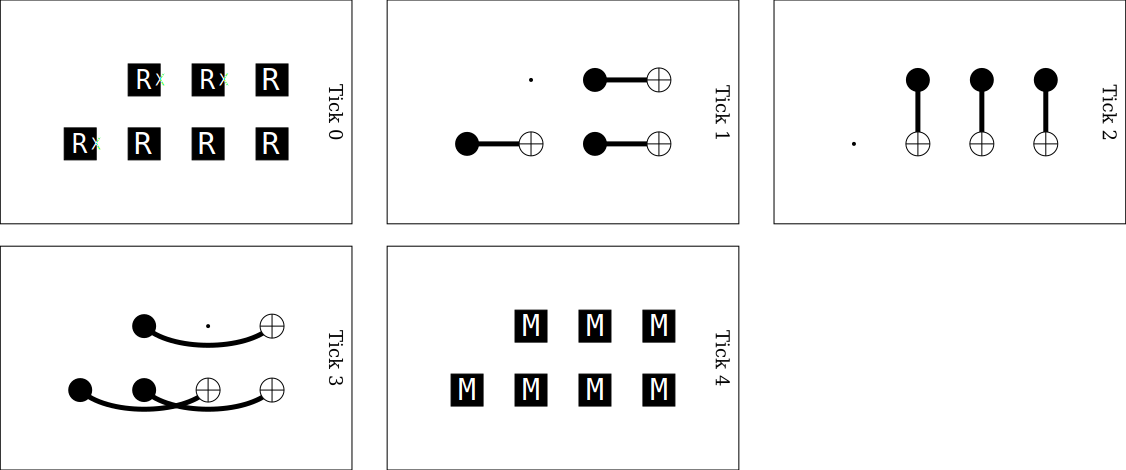

In [ ]:
# |0> state in Steane's code
noise = 0.001
Steane_circuit_bare = QRM_encode(1, 1, 3, [noise]*4, "Z", punctured, final_meas="Z")
Steane_circuit_bare.append_operation("OBSERVABLE_INCLUDE", [stim.target_rec(-k) for k in range(1, 8)], 0)  # Logical observables
Steane_circuit_bare.without_noise().diagram("detslice-with-ops-svg")

In [ ]:
Steane_circuit_bare

stim.Circuit('''
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(0, 1) 2
    QUBIT_COORDS(1, 1) 3
    QUBIT_COORDS(2, 0) 4
    QUBIT_COORDS(3, 0) 5
    QUBIT_COORDS(2, 1) 6
    QUBIT_COORDS(3, 1) 7
    RX 1 2 4
    Z_ERROR(0.001) 1 2 4
    R 3 5 6 7
    X_ERROR(0.001) 3 5 6 7
    TICK
    CX 2 3 4 5 6 7
    DEPOLARIZE2(0.001) 2 3 4 5 6 7
    TICK
    CX 1 3 4 6 5 7
    DEPOLARIZE2(0.001) 1 3 4 6 5 7
    TICK
    CX 1 5 2 6 3 7
    DEPOLARIZE2(0.001) 1 5 2 6 3 7
    TICK
    X_ERROR(0.001) 1 2 3 4 5 6 7
    M 1 2 3 4 5 6 7
    OBSERVABLE_INCLUDE(0) rec[-1] rec[-2] rec[-3] rec[-4] rec[-5] rec[-6] rec[-7]
''')

In [ ]:
# Add flag qubit postselection
Steane_circuit_flag = QRM_encode(1, 1, 3, [noise]*4, "Z", punctured, final_meas="None")
Steane_circuit_flag.append_operation("QUBIT_COORDS", [8], [4,0])  # Flag qubit at (4,0)
Steane_circuit_flag.append_operation("R", [8])  # Flag qubit at (4,0)
Steane_circuit_flag.append("TICK")
Steane_circuit_flag.append_operation("CX", [1, 8])
Steane_circuit_flag.append_operation("DEPOLARIZE2", [1, 8], noise)
Steane_circuit_flag.append("TICK")
Steane_circuit_flag.append_operation("CX", [2, 8])
Steane_circuit_flag.append_operation("DEPOLARIZE2", [2, 8], noise)
Steane_circuit_flag.append("TICK")
Steane_circuit_flag.append_operation("CX", [3, 8])
Steane_circuit_flag.append_operation("DEPOLARIZE2", [3, 8], noise)
Steane_circuit_flag.append("TICK")
Steane_circuit_flag.append_operation("X_ERROR", [8], noise)
Steane_circuit_flag.append_operation("M", range(1,9))
Steane_circuit_flag.append_operation("DETECTOR", [stim.target_rec(-1)], 0)  # Detector for flag qubit
Steane_circuit_flag.append_operation("OBSERVABLE_INCLUDE", [stim.target_rec(-k) for k in range(2, 9)], 0)  # Logical observables


In [ ]:
Steane_circuit_flag

stim.Circuit('''
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(0, 1) 2
    QUBIT_COORDS(1, 1) 3
    QUBIT_COORDS(2, 0) 4
    QUBIT_COORDS(3, 0) 5
    QUBIT_COORDS(2, 1) 6
    QUBIT_COORDS(3, 1) 7
    RX 1 2 4
    Z_ERROR(0.001) 1 2 4
    R 3 5 6 7
    X_ERROR(0.001) 3 5 6 7
    TICK
    CX 2 3 4 5 6 7
    DEPOLARIZE2(0.001) 2 3 4 5 6 7
    TICK
    CX 1 3 4 6 5 7
    DEPOLARIZE2(0.001) 1 3 4 6 5 7
    TICK
    CX 1 5 2 6 3 7
    DEPOLARIZE2(0.001) 1 5 2 6 3 7
    TICK
    QUBIT_COORDS(4, 0) 8
    R 8
    TICK
    CX 1 8
    DEPOLARIZE2(0.001) 1 8
    TICK
    CX 2 8
    DEPOLARIZE2(0.001) 2 8
    TICK
    CX 3 8
    DEPOLARIZE2(0.001) 3 8
    TICK
    X_ERROR(0.001) 8
    M 1 2 3 4 5 6 7 8
    DETECTOR(0) rec[-1]
    OBSERVABLE_INCLUDE(0) rec[-2] rec[-3] rec[-4] rec[-5] rec[-6] rec[-7] rec[-8]
''')

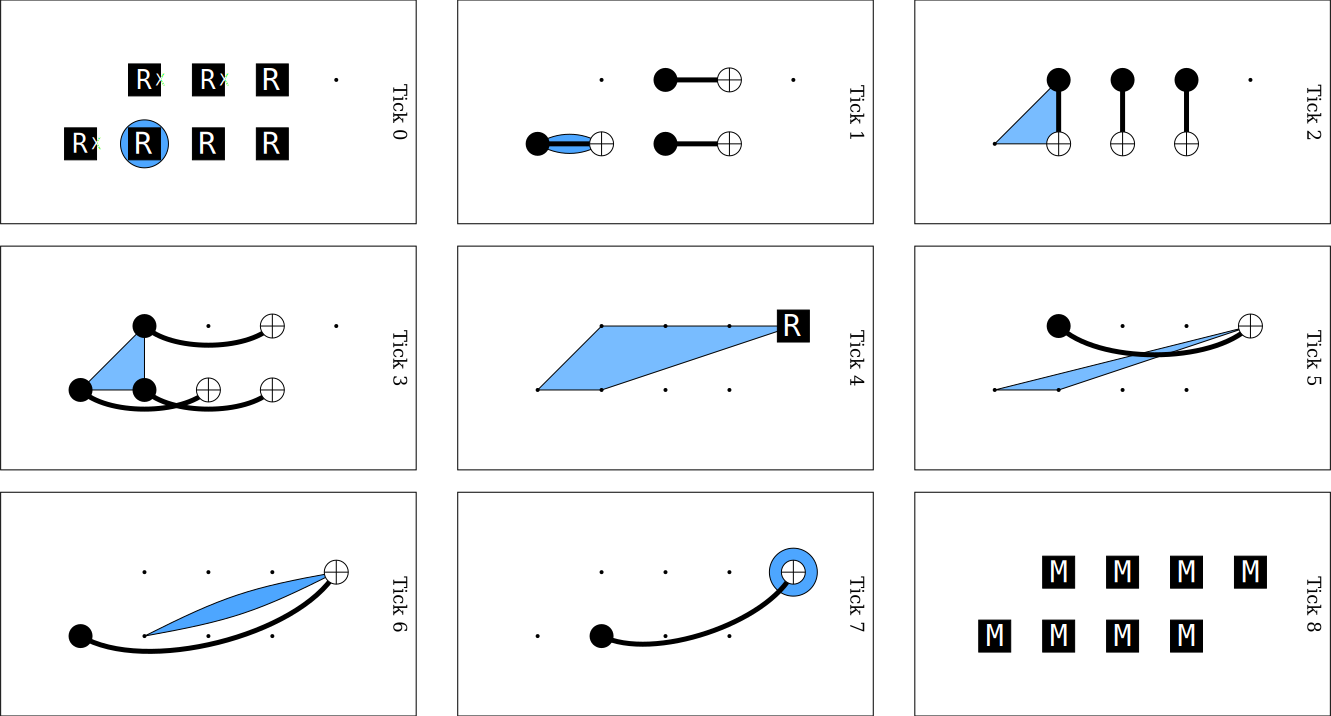

In [ ]:
Steane_circuit_flag.without_noise().diagram("detslice-with-ops-svg")

In [ ]:
flag_circuit = stim.Circuit('''
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(0, 1) 2
    QUBIT_COORDS(1, 1) 3
    QUBIT_COORDS(2, 0) 4
    QUBIT_COORDS(3, 0) 5
    QUBIT_COORDS(2, 1) 6
    QUBIT_COORDS(3, 1) 7
    QUBIT_COORDS(4, 0) 8
    RX 1 2 4
    Z_ERROR(0.01) 1 2 4
    R 3 5 6 7
    X_ERROR(0.01) 3 5 6 7
    TICK
    CX 2 3 4 5 6 7
    DEPOLARIZE2(0.01) 2 3 4 5 6 7
    TICK
    CX 1 3 4 6 5 7
    DEPOLARIZE2(0.01) 1 3 4 6 5 7
    TICK
    CX 1 5 2 6 3 7
    DEPOLARIZE2(0.01) 1 5 2 6 3 7
    TICK
    CX 1 8 2 8 3 8
    DEPOLARIZE2(0.01) 1 8 2 8 3 8
    R 8
    X_ERROR(0.01) 1 2 3 4 5 6 7 8
    M 1 2 3 4 5 6 7 8
    DETECTOR(0) rec[-1]
    OBSERVABLE_INCLUDE(0) rec[-2] rec[-3] rec[-4] rec[-5] rec[-6] rec[-7] rec[-8]
''')

In [ ]:
sample_num = 100000
samples_bare = Steane_circuit_bare.compile_detector_sampler().sample(sample_num, append_observables=True)
samples_flag = Steane_circuit_flag.compile_detector_sampler().sample(sample_num, append_observables=True)
postselected = [s for s in samples_flag if sum(s[:-1]) == 0]
len_post = len(postselected)
post_error = sum(s[-1] for s in postselected)

# Logical error rate with postselection
if len_post > 0:
    ler_post = post_error / len_post

print(f'non-FT LER: {np.sum(samples_bare, axis=0)[-1]/sample_num}')
print(f'Flag LER: {ler_post}')

non-FT LER: 0.01041
Flag LER: 0.004488366476129136


In [ ]:
len_post

99368

In [ ]:
len_post

99368

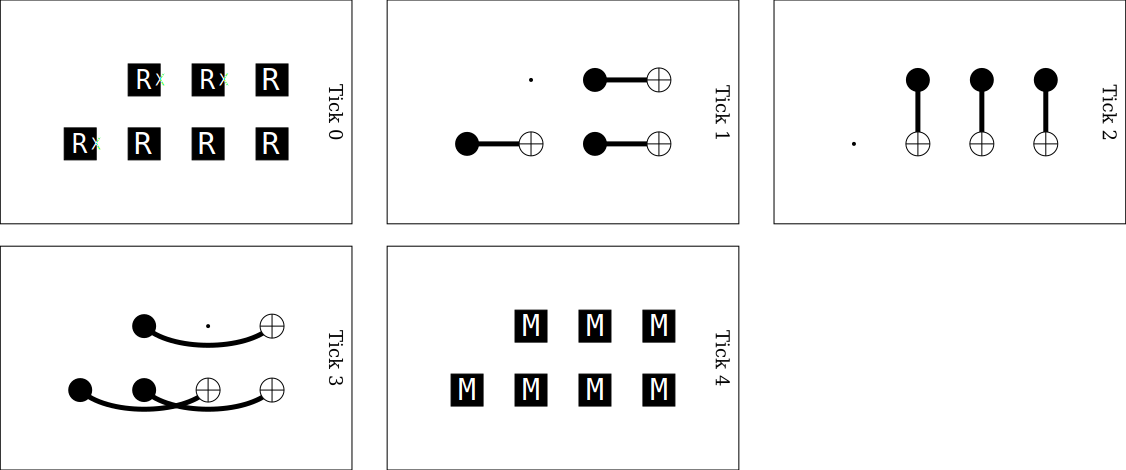

In [ ]:
Steane_circuit_bare.without_noise().diagram("detslice-with-ops-svg")

In [ ]:
steane_Goto = stim.Circuit('''
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(0, 1) 2
    QUBIT_COORDS(1, 1) 3
    QUBIT_COORDS(2, 0) 4
    QUBIT_COORDS(3, 0) 5
    QUBIT_COORDS(2, 1) 6
    QUBIT_COORDS(3, 1) 7
    QUBIT_COORDS(4, 0) 8
    RX 1 2 4
    Z_ERROR(0.001) 1 2 4
    R 3 5 6 7 8
    X_ERROR(0.001) 3 5 6 7
    TICK
    CX 1 5 2 3 4 6
    DEPOLARIZE2(0.001) 1 5 2 3 4 6
    TICK
    CX 1 7 4 5 2 6
    DEPOLARIZE2(0.001) 1 7 4 5 2 6
    TICK
    CX 1 3 6 7
    DEPOLARIZE2(0.001) 1 3 6 7
    TICK
    CX 3 8
    DEPOLARIZE2(0.001) 3 8
    TICK
    CX 5 8
    DEPOLARIZE2(0.001) 5 8
    TICK
    CX 6 8
    DEPOLARIZE2(0.001) 6 8
    TICK
    X_ERROR(0.01) 8
    M 1 2 3 4 5 6 7 8
    DETECTOR(0) rec[-1]
    OBSERVABLE_INCLUDE(0) rec[-2] rec[-3] rec[-4] rec[-5] rec[-6] rec[-7] rec[-8]
''')

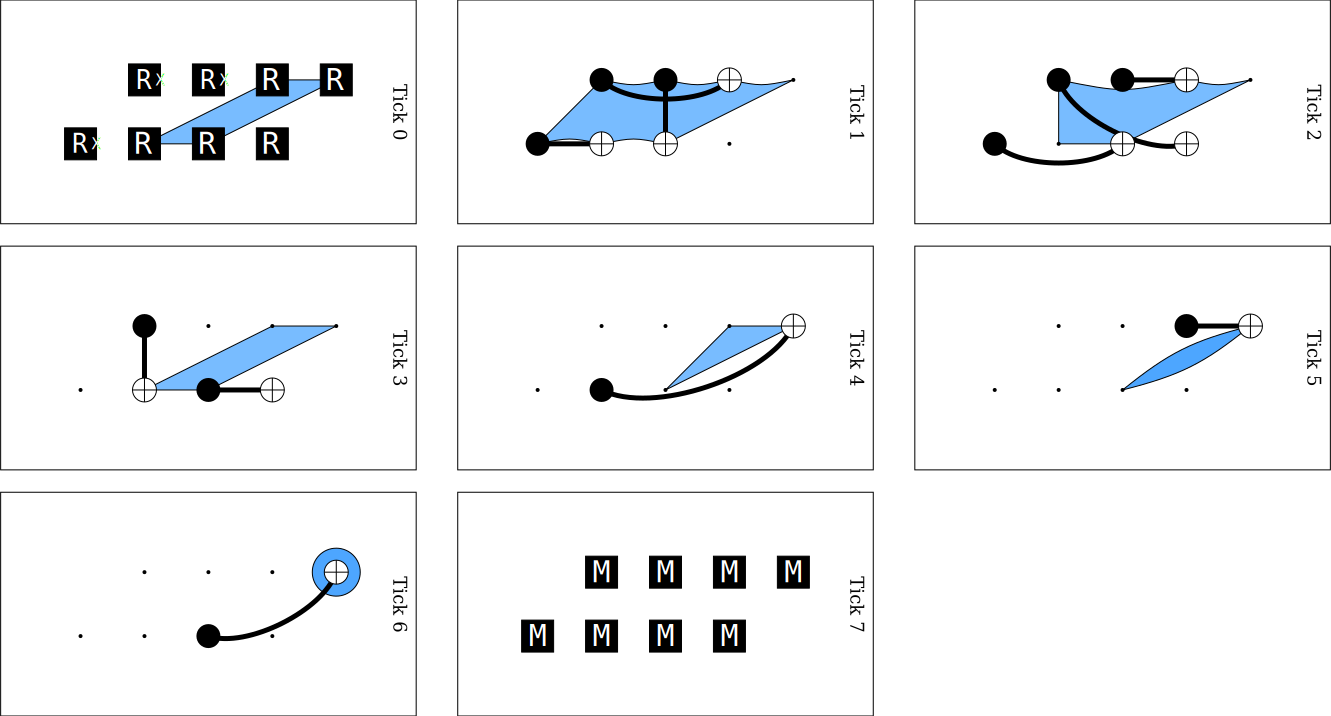

In [ ]:
steane_Goto.without_noise().diagram("detslice-with-ops-svg")

In [ ]:
sample_num = 1000000
samples_flag = steane_Goto.compile_detector_sampler().sample(sample_num, append_observables=True)
postselected = [s for s in samples_flag if sum(s[:-1]) == 0]
len_post = len(postselected)
post_error = sum(s[-1] for s in postselected)
print(f'Goto LER: {post_error / len_post if len_post > 0 else 0}')
print(f'Post-selection Rate: {len_post / sample_num}')

Goto LER: 0.0033108466147637877
Post-selection Rate: 0.98132
